In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops
from difflib import SequenceMatcher

In [12]:
persona_raw = pd.read_excel('persona.xlsx')
persona_raw.head()

,Persona_ID,Persona,Count_Users,Count_Apps,TOP1_APP,TOP2_APP,TOP3_APP
0,1,Art,2,28,PENUP Share your drawings,ibis Paint X,FlipaClip Cartoon animation
1,2,Auto,1,48,Android Auto Google Maps Media Messaging,CarMax Cars for Sale Search Used Car Inventory,DMV Genie Permit Practice Test Car CDL
2,3,Beauty,4,11,Sephora Buy Makeup Cosmetics Hair Skincare,Ulta Beauty Shop Makeup Skin Hair Perfume,IPSY Makeup Beauty and Tips
3,4,Books,23,315,Sky Map,Dictionary com Find Definitions for English Words,HOOKED Chat Stories
4,5,Business,133,382,Secure Folder,Visual Voicemail by MetroPCS,LinkedIn Jobs Business News Social Networking


In [14]:
apps_raw = pd.read_excel('Apps.xlsx')
apps_raw.head(5)

,App_ID,Title,Category,Score,Reviews,Download,Description,Count_Users
0,1,A Better Camera,PHOTOGRAPHY,4.1,78164,5000000,"All-purpose, full featured camera for Android:...",4
1,2,A Better Editor Effects,PHOTOGRAPHY,4.1,5272,500000,A Better Editor & Effects is a simple and easy...,3
2,3,A Blind Legend,GAME_ADVENTURE,4.3,16941,500000,It‚Äö√Ñ√¥s the first-ever mobile action-advent...,1
3,4,A Bomb Radio,MUSIC_AND_AUDIO,4.3,1177,50000,A-Bomb Radio combines all genres roughly betwe...,1
4,5,A C Moore Crafts,SHOPPING,3.2,2674,100000,"Create More, Share More, Save More‚Äö√Ñ¬∂ On t...",7


In [4]:
ratings_raw = pd.read_excel('Ratings.xlsx')
#ratings = ratings_raw.drop(columns = 'ID')
ratings_raw.head(2)

,Persona_ID,App_ID,Count_Installation
0,1,1,0
1,2,2,0


In [15]:
def load_data():
    #Read Persona Data
    persona = pd.read_excel('persona.xlsx')
    persona = persona.drop(columns = ['Persona'])
    #persona = persona.filter(regex='Persona_ID|Count_Users|Count_Apps')
    persona_orig = persona.values

    count_users_map = {val:ii for ii,val in enumerate(set(persona['Count_Users']))}
    persona['Count_Users'] = persona['Count_Users'].map(count_users_map)

    count_apps_map = {val:ii for ii,val in enumerate(set(persona['Count_Apps']))}
    persona['Count_Apps'] = persona['Count_Apps'].map(count_apps_map)
   
    top1_set = set()
    for val in persona['TOP1_APP'].str.split():
        top1_set.update(val)
    top1_set.add('<PAD>')
    top1_2int = {val:ii for ii, val in enumerate(top1_set)}
    top1_count = 15
    top1_map = {val:[top1_2int[row] for row in val.split()] for ii,val in enumerate(set(persona['TOP1_APP']))}

    for key in top1_map:
        for cnt in range(top1_count - len(top1_map[key])):
            top1_map[key].insert(len(top1_map[key]) + cnt,top1_2int['<PAD>'])
    persona['TOP1_APP'] = persona['TOP1_APP'].map(top1_map)
    
    top2_set = set()
    for val in persona['TOP2_APP'].str.split():
        top2_set.update(val)
    top2_set.add('<PAD>')
    top2_2int = {val:ii for ii, val in enumerate(top2_set)}
    top2_count = 15
    top2_map = {val:[top2_2int[row] for row in val.split()] for ii,val in enumerate(set(persona['TOP2_APP']))}
     
    for key in top2_map:
        for cnt in range(top2_count - len(top2_map[key])):
            top2_map[key].insert(len(top2_map[key]) + cnt,top2_2int['<PAD>'])
    persona['TOP2_APP'] = persona['TOP2_APP'].map(top2_map)
    
    top3_set = set()
    for val in persona['TOP3_APP'].str.split():
        top3_set.update(val)
    top3_set.add('<PAD>')
    top3_2int = {val:ii for ii, val in enumerate(top3_set)}
    top3_count = 15
    top3_map = {val:[top3_2int[row] for row in val.split()] for ii,val in enumerate(set(persona['TOP3_APP']))}
     
    for key in top3_map:
        for cnt in range(top3_count - len(top3_map[key])):
            top3_map[key].insert(len(top3_map[key]) + cnt,top3_2int['<PAD>'])
    persona['TOP3_APP'] = persona['TOP3_APP'].map(top3_map)
    
    
    #Read App(based on web scraping data) Data
    apps = pd.read_excel('Apps.xlsx')
    apps= apps.drop(columns = ['Description','Count_Users'])
    apps_orig = apps.values
    
    title_set = set()
    for val in apps['Title'].str.split():
        title_set.update(val)

    title_set.add('<PAD>')
    title2int = {val:ii for ii, val in enumerate(title_set)}
    title_count = 15
    title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(apps['Title']))}
     
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    apps['Title'] = apps['Title'].map(title_map)

    #update category into numeric 
    category_set = set()
    for val in apps['Category'].str.split('|'):
        category_set.update(val)

    category_set.add('<PAD>')
    category2int = {val:ii for ii, val in enumerate(category_set)}
    
    category_map = {val:[category2int[row] for row in val.split('|')] for ii,val in enumerate(set(apps['Category']))}

    for key in category_map:
        for cnt in range(max(category2int.values()) - len(category_map[key])):
            category_map[key].insert(len(category_map[key]) + cnt,category2int['<PAD>'])
    
    apps['Category'] = apps['Category'].map(category_map)
    
    # read score column
    score_map = {val:ii for ii,val in enumerate(set(apps['Score']))}
    apps['Score'] = apps['Score'].map(score_map)
    
    # read review column
    reviews_map = {val:ii for ii,val in enumerate(set(apps['Reviews']))}
    apps['Reviews'] = apps['Reviews'].map(reviews_map)
    
    # read downloads column
    download_map = {val:ii for ii,val in enumerate(set(apps['Download']))}
    apps['Download'] = apps['Download'].map(download_map)
    
    
    # Read rating (persona and mobile app interactions)
    ratings = pd.read_excel('Ratings.xlsx')
    ratings = ratings.filter(regex='Persona_ID|App_ID|Count_Installation')

    # Combine All 3 tables
    data = pd.merge(pd.merge(ratings, persona), apps)
    
    #split dependent and indepdent variavles
    target_fields = ['Count_Installation']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return top1_count, top1_set, top2_count, top2_set, top3_count, top3_set, title_count, title_set, category2int, features, targets_values, ratings, persona, apps, data, apps_orig, persona_orig

In [16]:
top1_count, top1_set, top2_count, top2_set, top3_count, top3_set, title_count, title_set, category2int, features, targets_values, ratings, persona, apps, data, apps_orig, persona_orig = load_data()

pickle.dump((top1_count, top1_set, top2_count, top2_set, top3_count, top3_set, title_count, title_set, category2int, features, targets_values, ratings, persona, apps, data, apps_orig, persona_orig), open('preprocess.p', 'wb'))

In [17]:
target_fields = ['Count_Installation']
features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]

features_pd.head(1)

,Persona_ID,App_ID,Count_Users,Count_Apps,TOP1_APP,TOP2_APP,TOP3_APP,Title,Category,Score,Reviews,Download
0,1,1,1,15,"[98, 18, 67, 53, 55, 55, 55, 55, 55, 55, 55, 5...","[19, 96, 79, 59, 59, 59, 59, 59, 59, 59, 59, 5...","[25, 2, 9, 62, 62, 62, 62, 62, 62, 62, 62, 62,...","[6537, 2115, 6862, 10542, 10542, 10542, 10542,...","[51, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 4...",5,5761,14


In [18]:
#targets_pd.head(1)

In [19]:
top1_count, top1_set, top2_count, top2_set, top3_count, top3_set, title_count, title_set, category2int, features, targets_values, ratings, persona, apps, data, apps_orig, persona_orig = pickle.load(open('preprocess.p', mode='rb'))

In [20]:
import tensorflow as tf
import os
import pickle

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))

In [21]:
embed_dim = 32
# persona
persona_id_max = max(features.take(0,1)) + 1  #44+1
persona_count_users_max = max(features.take(2,1)) + 1 #33+1
persona_count_apps_max = max(features.take(3,1)) +1 #43+1
top1_title_max = len(top1_set)      #143
top2_title_max = len(top2_set)      #148
top3_title_max = len(top3_set)      #147

#apps
app_id_max = max(features.take(1,1)) + 1          # 13101+1
app_title_max = len(title_set)                    # 12364
app_category_max = max(category2int.values()) +1  # 56+1         
app_score_max = max(features.take(9,1)) + 1       # 40+1
app_reviews_max = max(features.take(10,1)) + 1    #9052+1
app_download_max = max(features.take(11,1)) + 1   #19+1

combiner = "sum"

sentences_size = title_count 
window_sizes = {2, 3, 4, 5}
filter_num = 8

appid2idx = {val[0]:i for i, val in enumerate(apps.values)}
personaid2idx = {val[0]:i for i, val in enumerate(persona.values)}

In [22]:
# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256

dropout_keep = 0.5
# Learning Rate
learning_rate = 0.001
# Show stats for every n number of batches
show_every_n_batches = 20

save_dir = './save'

In [23]:
def get_inputs():
    persona_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='persona_id')  
    persona_count_users = tf.keras.layers.Input(shape=(1,), dtype='int32', name='persona_count_users')
    persona_count_apps = tf.keras.layers.Input(shape=(1,), dtype='int32', name='persona_count_apps')
    top1_title = tf.keras.layers.Input(shape=(15,), dtype='int32', name='top1_title')
    top2_title = tf.keras.layers.Input(shape=(15,), dtype='int32', name='top2_title')
    top3_title = tf.keras.layers.Input(shape=(15,), dtype='int32', name='top3_title')

    app_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='app_id') 
    app_title = tf.keras.layers.Input(shape=(15,), dtype='int32', name='app_title')
    app_category = tf.keras.layers.Input(shape=(56,), dtype='int32', name='app_category') 
    app_score = tf.keras.layers.Input(shape=(1,), dtype='int32', name='app_score') 
    app_reviews = tf.keras.layers.Input(shape=(1,), dtype='int32', name='app_reviews')
    app_download = tf.keras.layers.Input(shape=(1,), dtype='int32', name='app_download')
    return persona_id,persona_count_users,persona_count_apps,top1_title,top2_title,top3_title,app_id,app_title,app_category,app_score,app_reviews,app_download


In [24]:
def get_persona_id_embed_layer(persona_id):
    persona_id_embed_layer = tf.keras.layers.Embedding(persona_id_max, embed_dim, input_length=1, name='persona_id_embed_layer')(persona_id)
    return persona_id_embed_layer

In [25]:
def get_persona_count_users_embed_layer(persona_count_users):
    persona_count_users_embed_layer = tf.keras.layers.Embedding(persona_count_users_max, embed_dim, input_length=1, name='persona_count_users_embed_layer')(persona_count_users)
    return persona_count_users_embed_layer

In [26]:
def get_persona_count_apps_embed_layer(persona_count_apps):
    persona_count_apps_embed_layer = tf.keras.layers.Embedding(persona_count_apps_max, embed_dim, input_length=1, name='persona_count_apps_embed_layer')(persona_count_apps)
    return persona_count_apps_embed_layer

In [27]:
def get_persona_top1_cnn_layer(top1_title):
    top1_title_embed_layer = tf.keras.layers.Embedding(top1_title_max, embed_dim, input_length=15, name='persona_top1_embed_layer')(top1_title)
    sp=top1_title_embed_layer.shape
    top1_title_embed_layer_expand = tf.keras.layers.Reshape([sp[1], sp[2], 1])(top1_title_embed_layer)
    pool_layer_lst1 = []
    
    for window_size in window_sizes:
        conv_layer1 = tf.keras.layers.Conv2D(filter_num, (window_size, embed_dim), 1, activation='relu')(top1_title_embed_layer_expand)
        maxpool_layer1 = tf.keras.layers.MaxPooling2D(pool_size=(sentences_size - window_size + 1 ,1), strides=1)(conv_layer1)
        pool_layer_lst1.append(maxpool_layer1)
    
    #Dropout Layer
    pool_layer1 = tf.keras.layers.concatenate(pool_layer_lst1, 3, name ="pool_layer1")  
    max_num = len(window_sizes) * filter_num
    pool_layer_flat1 = tf.keras.layers.Reshape([1, max_num], name = "pool_layer_flat1")(pool_layer1)

    dropout_layer1 = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer1")(pool_layer_flat1)
    return pool_layer_flat1, dropout_layer1

In [28]:
def get_persona_top2_cnn_layer(top2_title):
    top2_title_embed_layer = tf.keras.layers.Embedding(top2_title_max, embed_dim, input_length=15, name='persona_top2_embed_layer')(top2_title)
    sp=top2_title_embed_layer.shape
    top2_title_embed_layer_expand = tf.keras.layers.Reshape([sp[1], sp[2], 1])(top2_title_embed_layer)
    pool_layer_lst2 = []
    
    for window_size in window_sizes:
        conv_layer2 = tf.keras.layers.Conv2D(filter_num, (window_size, embed_dim), 1, activation='relu')(top2_title_embed_layer_expand)
        maxpool_layer2 = tf.keras.layers.MaxPooling2D(pool_size=(sentences_size - window_size + 1 ,1), strides=1)(conv_layer2)
        pool_layer_lst2.append(maxpool_layer2)
    
    #Dropout Layer
    pool_layer2 = tf.keras.layers.concatenate(pool_layer_lst2, 3, name ="pool_layer2")  
    max_num = len(window_sizes) * filter_num
    pool_layer_flat2 = tf.keras.layers.Reshape([1, max_num], name = "pool_layer_flat2")(pool_layer2)

    dropout_layer2 = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer2")(pool_layer_flat2)
    return pool_layer_flat2, dropout_layer2

In [29]:
def get_persona_top3_cnn_layer(top3_title):
    top3_title_embed_layer = tf.keras.layers.Embedding(top3_title_max, embed_dim, input_length=15, name='persona_top3_embed_layer')(top3_title)
    sp=top3_title_embed_layer.shape
    top3_title_embed_layer_expand = tf.keras.layers.Reshape([sp[1], sp[2], 1])(top3_title_embed_layer)
    pool_layer_lst3 = []
    
    for window_size in window_sizes:
        conv_layer3 = tf.keras.layers.Conv2D(filter_num, (window_size, embed_dim), 1, activation='relu')(top3_title_embed_layer_expand)
        maxpool_layer3 = tf.keras.layers.MaxPooling2D(pool_size=(sentences_size - window_size + 1 ,1), strides=1)(conv_layer3)
        pool_layer_lst3.append(maxpool_layer3)
    
    #Dropout Layer
    pool_layer3 = tf.keras.layers.concatenate(pool_layer_lst3, 3, name ="pool_layer3")  
    max_num = len(window_sizes) * filter_num
    pool_layer_flat3 = tf.keras.layers.Reshape([1, max_num], name = "pool_layer_flat3")(pool_layer3)

    dropout_layer3 = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer3")(pool_layer_flat3)
    return pool_layer_flat3, dropout_layer3

In [30]:
def get_persona_feature_layer(persona_id_embed_layer,persona_count_users_embed_layer,persona_count_apps_embed_layer,dropout_layer1,dropout_layer2,dropout_layer3):
    
    #First Layer
    persona_id_fc_layer = tf.keras.layers.Dense(embed_dim, name="persona_id_fc_layer", activation='relu')(persona_id_embed_layer)
    persona_count_users_fc_layer = tf.keras.layers.Dense(embed_dim, name="persona_count_users_fc_layer", activation='relu')(persona_count_users_embed_layer)
    persona_count_apps_fc_layer = tf.keras.layers.Dense(embed_dim, name="persona_count_apps_fc_layer", activation='relu')(persona_count_apps_embed_layer)
    
    #Second Layer
    persona_combine_layer = tf.keras.layers.concatenate([persona_id_fc_layer, persona_count_users_fc_layer,persona_count_apps_fc_layer, dropout_layer1,dropout_layer2,dropout_layer3], 2)  
    persona_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(persona_combine_layer)

    persona_combine_layer_flat = tf.keras.layers.Reshape([200], name="persona_combine_layer_flat")(persona_combine_layer)
    return persona_combine_layer, persona_combine_layer_flat

In [31]:
def get_app_id_embed_layer(app_id):
    app_id_embed_layer = tf.keras.layers.Embedding(app_id_max, embed_dim, input_length=1, name='app_id_embed_layer')(app_id)
    return app_id_embed_layer

In [32]:
def get_app_category_layer(app_category):
    app_category_embed_layer = tf.keras.layers.Embedding(app_category_max, embed_dim, input_length=56, name='app_category_embed_layer')(app_category)
    app_category_embed_layer = tf.keras.layers.Lambda(lambda layer: tf.reduce_sum(layer, axis=1, keepdims=True))(app_category_embed_layer)
    #app_category_embed_layer = tf.keras.layers.Reshape([1, 62 * embed_dim])(app_category_embed_layer)

    return app_category_embed_layer

In [33]:
def get_app_score_embed_layer(app_score):
    app_score_embed_layer = tf.keras.layers.Embedding(app_score_max, embed_dim, input_length=1, name='app_score_embed_layer')(app_score)
    return app_score_embed_layer

In [34]:
def get_app_reviews_embed_layer(app_reviews):
    app_reviews_embed_layer = tf.keras.layers.Embedding(app_reviews_max, embed_dim, input_length=1, name='app_reviews_embed_layer')(app_reviews)
    return app_reviews_embed_layer

In [35]:
def get_app_download_embed_layer(app_download):
    app_download_embed_layer = tf.keras.layers.Embedding(app_download_max, embed_dim, input_length=1, name='app_download_embed_layer')(app_download)
    return app_download_embed_layer

In [36]:
def get_app_cnn_layer(app_title):
    app_title_embed_layer = tf.keras.layers.Embedding(app_title_max, embed_dim, input_length=15, name='app_title_embed_layer')(app_title)
    sp=app_title_embed_layer.shape
    app_title_embed_layer_expand = tf.keras.layers.Reshape([sp[1], sp[2], 1])(app_title_embed_layer)
    pool_layer_lst = []
    
    for window_size in window_sizes:
        conv_layer = tf.keras.layers.Conv2D(filter_num, (window_size, embed_dim), 1, activation='relu')(app_title_embed_layer_expand)
        maxpool_layer = tf.keras.layers.MaxPooling2D(pool_size=(sentences_size - window_size + 1 ,1), strides=1)(conv_layer)
        pool_layer_lst.append(maxpool_layer)
    
    #Dropout Layer
    pool_layer = tf.keras.layers.concatenate(pool_layer_lst, 3, name ="pool_layer")  
    max_num = len(window_sizes) * filter_num
    pool_layer_flat = tf.keras.layers.Reshape([1, max_num], name = "pool_layer_flat")(pool_layer)

    dropout_layer = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer")(pool_layer_flat)
    return pool_layer_flat, dropout_layer

In [37]:
def get_app_feature_layer(app_id_embed_layer, app_category_embed_layer,app_score_embed_layer, app_reviews_embed_layer,app_download_embed_layer, dropout_layer):
    #First Layer
    app_id_fc_layer = tf.keras.layers.Dense(embed_dim, name="app_id_fc_layer", activation='relu')(app_id_embed_layer)
    app_category_fc_layer = tf.keras.layers.Dense(embed_dim, name="app_category_fc_layer", activation='relu')(app_category_embed_layer)
    app_score_fc_layer = tf.keras.layers.Dense(embed_dim, name="app_score_fc_layer", activation='relu')(app_score_embed_layer)
    app_reviews_fc_layer = tf.keras.layers.Dense(embed_dim, name="app_reviews_fc_layer", activation='relu')(app_reviews_embed_layer)
    app_download_fc_layer = tf.keras.layers.Dense(embed_dim, name="app_download_fc_layer", activation='relu')(app_download_embed_layer)
    
    #Second Layer
    app_combine_layer = tf.keras.layers.concatenate([app_id_fc_layer, app_category_fc_layer,app_score_fc_layer, app_reviews_fc_layer,app_download_fc_layer, dropout_layer], 2)  
    app_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(app_combine_layer)

    app_combine_layer_flat = tf.keras.layers.Reshape([200], name="app_combine_layer_flat")(app_combine_layer)
    return app_combine_layer, app_combine_layer_flat

In [38]:
#tf.keras.layers

In [39]:
#targets_values

In [40]:
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.python.ops import summary_ops_v2
import time

MODEL_DIR = "./models"


class mv_network(object):
    def __init__(self, batch_size=256):
        self.batch_size = batch_size
        self.best_loss = 9999
        self.losses = {'train': [], 'test': []}

        persona_id, persona_count_users, persona_count_apps,top1_title,top2_title,top3_title, app_id, app_title, app_category, app_score, app_reviews, app_download = get_inputs()
        
        # Step 1: Start with persona
        persona_id_embed_layer = get_persona_id_embed_layer(persona_id)      
        persona_count_users_embed_layer = get_persona_count_users_embed_layer(persona_count_users)
        persona_count_apps_embed_layer = get_persona_count_apps_embed_layer(persona_count_apps)
        pool_layer_flat1, dropout_layer1 = get_persona_top1_cnn_layer(top1_title)
        pool_layer_flat2, dropout_layer2 = get_persona_top2_cnn_layer(top2_title)
        pool_layer_flat3, dropout_layer3 = get_persona_top3_cnn_layer(top3_title)
        
                                                                                                                       
        # persona features
        persona_combine_layer, persona_combine_layer_flat = get_persona_feature_layer(persona_id_embed_layer,
                                                                                      persona_count_users_embed_layer,
                                                                                      persona_count_apps_embed_layer,
                                                                                      dropout_layer1,
                                                                                      dropout_layer2,
                                                                                      dropout_layer3)
        
        # Step 2: Then move to apps
        app_id_embed_layer = get_app_id_embed_layer(app_id)
        # app category
        app_category_embed_layer = get_app_category_layer(app_category)
        # app title
        pool_layer_flat, dropout_layer = get_app_cnn_layer(app_title)
        # app score
        app_score_embed_layer = get_app_score_embed_layer(app_score)
        # app reviews
        app_reviews_embed_layer = get_app_reviews_embed_layer(app_reviews)
        # app download
        app_download_embed_layer = get_app_download_embed_layer(app_download)
        
        # app features
        app_combine_layer, app_combine_layer_flat = get_app_feature_layer(app_id_embed_layer, 
                                                                          app_category_embed_layer,
                                                                          app_score_embed_layer, 
                                                                          app_reviews_embed_layer,
                                                                          app_download_embed_layer, 
                                                                          dropout_layer)

        
        
        #Calculate Ratings
        inference = tf.keras.layers.Lambda(lambda layer: tf.reduce_sum(layer[0] * layer[1], axis=1), name="inference")((persona_combine_layer_flat, app_combine_layer_flat))
        inference = tf.keras.layers.Lambda(lambda layer: tf.expand_dims(layer, axis=1))(inference)

        self.model = tf.keras.Model(inputs=[persona_id, 
                                            persona_count_users, 
                                            persona_count_apps,
                                            top1_title,top2_title,top3_title, 
                                            app_id,
                                            app_title,
                                            app_category,
                                            app_score,
                                            app_reviews,
                                            app_download],outputs=[inference])

        self.model.summary()

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        
        
        # MSE Lost
        self.ComputeLoss = tf.keras.losses.MeanSquaredError()
        self.ComputeMetrics = tf.keras.metrics.MeanAbsoluteError()

        if tf.io.gfile.exists(MODEL_DIR):
            pass
        else:
            tf.io.gfile.makedirs(MODEL_DIR)

        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(MODEL_DIR, 'summaries', 'eval')
        
        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    def compute_loss(self, labels, logits):
        return tf.reduce_mean(tf.keras.losses.mse(labels, logits))

    def compute_metrics(self, labels, logits):
        return tf.keras.metrics.mae(labels, logits)  

    @tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            logits = self.model([x[0],
                                 x[1],
                                 x[2],
                                 x[3],
                                 x[4],
                                 x[5],
                                 x[6],
                                 x[7],
                                 x[8],
                                 x[9],
                                 x[10],
                                 x[11]], training=True)
            loss = self.ComputeLoss(y, logits)

            self.ComputeMetrics(y, logits)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, logits

    def training(self, features, targets_values, epochs=5, log_freq=50):

        for epoch_i in range(epochs):
            train_X, test_X, train_y, test_y = train_test_split(features,targets_values,test_size=0.2,random_state=0)

            train_batches = get_batches(train_X, train_y, self.batch_size)
            batch_num = (len(train_X) // self.batch_size)

            train_start = time.time()
            if True:
                start = time.time()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
                for batch_i in range(batch_num):
                    x, y = next(train_batches)
                     
                    top1_title = np.zeros([self.batch_size, sentences_size])
                    for i in range(self.batch_size):
                        top1_title[i] = x.take(4, 1)[i]
                        
                    top2_title = np.zeros([self.batch_size, sentences_size])
                    for i in range(self.batch_size):
                        top2_title[i] = x.take(5, 1)[i]
                        
                    top3_title = np.zeros([self.batch_size, sentences_size])
                    for i in range(self.batch_size):
                        top3_title[i] = x.take(6, 1)[i]
                        
                    title = np.zeros([self.batch_size, sentences_size])
                    for i in range(self.batch_size):
                        title[i] = x.take(7, 1)[i]
                    
                    category = np.zeros([self.batch_size, 56])
                    for i in range(self.batch_size):
                        category[i] = x.take(8, 1)[i]
                
                    
                    loss, logits = self.train_step([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                                    top1_title.astype(np.float32),
                                                    top2_title.astype(np.float32),
                                                    top3_title.astype(np.float32),
                                                    np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                                    title.astype(np.float32),
                                                    category.astype(np.float32),
                                                    np.reshape(x.take(9, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(10, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(11, 1), [self.batch_size, 1]).astype(np.float32)],
                                                   np.reshape(y, [self.batch_size, 1]).astype(np.float32)) #error earlier
                    avg_loss(loss)
                    
                    self.losses['train'].append(loss)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tEpoch {:>3} Batch {:>4}/{}   Loss: {:0.6f} mae: {:0.6f} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(),
                            epoch_i,
                            batch_i,
                            batch_num,
                            loss, (self.ComputeMetrics.result()), rate))
                        avg_loss.reset_states()
                        self.ComputeMetrics.reset_states()
                        start = time.time()

            train_end = time.time()
            print( '\nTrain time for epoch #{} ({} total steps): {}'.format(epoch_i + 1, self.optimizer.iterations.numpy(),
                                                                         train_end - train_start))
            self.testing((test_X, test_y), self.optimizer.iterations)
        self.export_path = os.path.join(MODEL_DIR, 'export')
        tf.saved_model.save(self.model, self.export_path)

    def testing(self, test_dataset, step_num):
        test_X, test_y = test_dataset
        test_batches = get_batches(test_X, test_y, self.batch_size)

        """Perform an evaluation of `model` on the examples from `dataset`."""
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

        batch_num = (len(test_X) // self.batch_size)
        for batch_i in range(batch_num):
            x, y = next(test_batches)
            
            top1_title = np.zeros([self.batch_size, sentences_size])
            for i in range(self.batch_size):
                top1_title[i] = x.take(4, 1)[i]
                        
            top2_title = np.zeros([self.batch_size, sentences_size])
            for i in range(self.batch_size):
                top2_title[i] = x.take(5, 1)[i]
                        
            top3_title = np.zeros([self.batch_size, sentences_size])
            for i in range(self.batch_size):
                top3_title[i] = x.take(6, 1)[i]
                        
            title = np.zeros([self.batch_size, sentences_size])
            for i in range(self.batch_size):
                title[i] = x.take(7, 1)[i]
            
            category = np.zeros([self.batch_size, 56])
            for i in range(self.batch_size):
                category[i] = x.take(8, 1)[i]
                    

            logits = self.model([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32), 
                                 np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                 top1_title.astype(np.float32),
                                 top2_title.astype(np.float32),
                                 top3_title.astype(np.float32),
                                 np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                 title.astype(np.float32),
                                 category.astype(np.float32),
                                 np.reshape(x.take(9, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(10, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(11, 1), [self.batch_size, 1]).astype(np.float32)], training=False)
            test_loss = self.ComputeLoss(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            avg_loss(test_loss)
            self.losses['test'].append(test_loss)
            self.ComputeMetrics(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)

        print('Model test set loss: {:0.6f} mae: {:0.6f}'.format(avg_loss.result(), self.ComputeMetrics.result()))

        if avg_loss.result() < self.best_loss:
            self.best_loss = avg_loss.result()
            print("best loss = {}".format(self.best_loss))
            self.checkpoint.save(self.checkpoint_prefix)

    def forward(self, xs):
        predictions = self.model(xs)
        return predictions

In [41]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

In [36]:
mv_net=mv_network()
#mv_net.training(features, targets_values, epochs=5)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
top1_title (InputLayer)         [(None, 15)]         0                                            
__________________________________________________________________________________________________
top2_title (InputLayer)         [(None, 15)]         0                                            
__________________________________________________________________________________________________
top3_title (InputLayer)         [(None, 15)]         0                                            
__________________________________________________________________________________________________
app_title (InputLayer)          [(None, 15)]         0                                            
______________________________________________________________________________________________

Step #50	Epoch   0 Batch   49/1801   Loss: 32.558529 mae: 0.472841 (5.241460481465107 steps/sec)
Step #100	Epoch   0 Batch   99/1801   Loss: 0.371808 mae: 0.596057 (16.212032135685725 steps/sec)
Step #150	Epoch   0 Batch  149/1801   Loss: 0.476215 mae: 0.667348 (13.532212979142415 steps/sec)
Step #200	Epoch   0 Batch  199/1801   Loss: 160.100464 mae: 0.514603 (15.107680708299322 steps/sec)
Step #250	Epoch   0 Batch  249/1801   Loss: 4.301359 mae: 0.646122 (14.963263818539374 steps/sec)
Step #300	Epoch   0 Batch  299/1801   Loss: 2.421463 mae: 1.193080 (14.922242748009694 steps/sec)
Step #350	Epoch   0 Batch  349/1801   Loss: 4.369101 mae: 0.978811 (15.147052631145586 steps/sec)
Step #400	Epoch   0 Batch  399/1801   Loss: 1.571963 mae: 1.090487 (14.805291000659237 steps/sec)
Step #450	Epoch   0 Batch  449/1801   Loss: 1.750473 mae: 1.250752 (14.528995715954265 steps/sec)
Step #500	Epoch   0 Batch  499/1801   Loss: 5.524129 mae: 1.250268 (14.143575822213638 steps/sec)
Step #550	Epoch   0

Step #4100	Epoch   2 Batch  497/1801   Loss: 0.376987 mae: 0.364822 (14.531356491463221 steps/sec)
Step #4150	Epoch   2 Batch  547/1801   Loss: 1.867693 mae: 0.368521 (14.63769650485937 steps/sec)
Step #4200	Epoch   2 Batch  597/1801   Loss: 0.265080 mae: 0.213141 (14.638039797924536 steps/sec)
Step #4250	Epoch   2 Batch  647/1801   Loss: 0.286975 mae: 0.417486 (14.632753235910123 steps/sec)
Step #4300	Epoch   2 Batch  697/1801   Loss: 0.372572 mae: 0.258930 (14.667355616399727 steps/sec)
Step #4350	Epoch   2 Batch  747/1801   Loss: 0.652381 mae: 0.262958 (14.676348388878388 steps/sec)
Step #4400	Epoch   2 Batch  797/1801   Loss: 48.512566 mae: 0.300826 (14.717084384256065 steps/sec)
Step #4450	Epoch   2 Batch  847/1801   Loss: 0.174817 mae: 0.369016 (14.733160838345313 steps/sec)
Step #4500	Epoch   2 Batch  897/1801   Loss: 0.094501 mae: 0.255103 (14.507134890112095 steps/sec)
Step #4550	Epoch   2 Batch  947/1801   Loss: 0.156444 mae: 0.277566 (14.68806238437141 steps/sec)
Step #4600	

Step #8100	Epoch   4 Batch  895/1801   Loss: 0.286064 mae: 0.211138 (11.88491386130489 steps/sec)
Step #8150	Epoch   4 Batch  945/1801   Loss: 0.115956 mae: 0.219476 (12.07072876822335 steps/sec)
Step #8200	Epoch   4 Batch  995/1801   Loss: 1.582733 mae: 0.203810 (12.453793805657579 steps/sec)
Step #8250	Epoch   4 Batch 1045/1801   Loss: 0.478981 mae: 0.429411 (13.235307018249705 steps/sec)
Step #8300	Epoch   4 Batch 1095/1801   Loss: 0.364183 mae: 0.264816 (13.739673225198084 steps/sec)
Step #8350	Epoch   4 Batch 1145/1801   Loss: 0.185455 mae: 0.270930 (13.61404847197764 steps/sec)
Step #8400	Epoch   4 Batch 1195/1801   Loss: 0.480076 mae: 0.280184 (13.577541305558515 steps/sec)
Step #8450	Epoch   4 Batch 1245/1801   Loss: 863.179993 mae: 0.269507 (13.049063161350393 steps/sec)
Step #8500	Epoch   4 Batch 1295/1801   Loss: 0.334126 mae: 0.305017 (13.349392181998926 steps/sec)
Step #8550	Epoch   4 Batch 1345/1801   Loss: 0.071500 mae: 0.212642 (13.391879553595501 steps/sec)
Step #8600	

In [56]:
mv_net=mv_network()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
top1_title (InputLayer)         [(None, 15)]         0                                            
__________________________________________________________________________________________________
top2_title (InputLayer)         [(None, 15)]         0                                            
__________________________________________________________________________________________________
top3_title (InputLayer)         [(None, 15)]         0                                            
__________________________________________________________________________________________________
app_title (InputLayer)          [(None, 15)]         0                                            
______________________________________________________________________________________________

In [68]:
mv_net.ComputeMetrics.result()

<tf.Tensor: id=2826, shape=(), dtype=float32, numpy=0.0>

In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

#plt.plot(mv_net.losses['train'], label='Training loss')
#plt.legend()
#_ = plt.ylim()

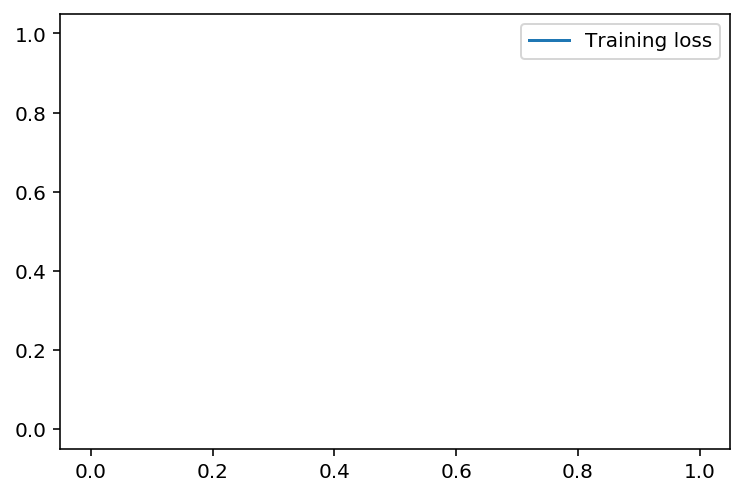

In [69]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(mv_net.losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

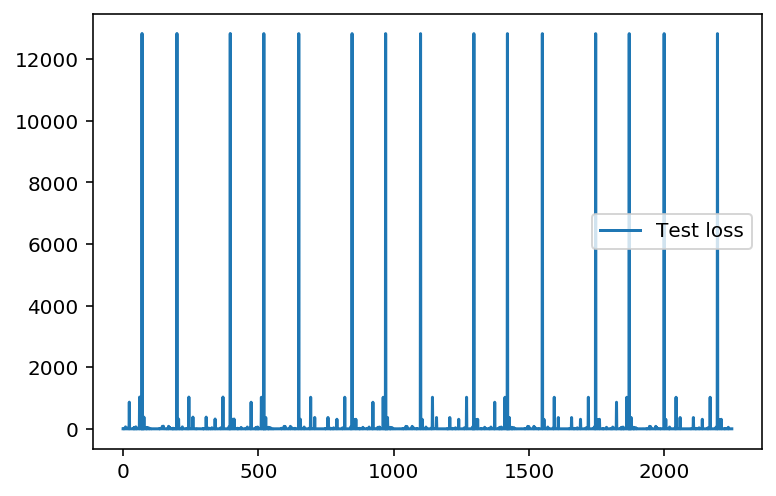

In [38]:
#plt.plot(mv_net.losses['test'], label='Test loss')
#plt.legend()
#_ = plt.ylim()

In [39]:
apps.head()

,App_ID,Title,Category,Score,Reviews,Download
0,1,"[10417, 11395, 2668, 6554, 6554, 6554, 6554, 6...","[16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...",5,5761,14
1,2,"[10417, 11395, 231, 5359, 6554, 6554, 6554, 65...","[16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...",5,3581,11
2,3,"[10417, 1306, 3074, 6554, 6554, 6554, 6554, 65...","[24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...",6,6629,11
3,4,"[10417, 5963, 2346, 6554, 6554, 6554, 6554, 65...","[50, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...",6,1140,16
4,5,"[10417, 4758, 6731, 8465, 6554, 6554, 6554, 65...","[46, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...",3,2267,12


In [40]:
persona.head()

,Persona_ID,Count_Users,Count_Apps,TOP1_APP,TOP2_APP,TOP3_APP
0,1,1,15,"[102, 75, 62, 53, 94, 94, 94, 94, 94, 94, 94, ...","[124, 67, 45, 91, 91, 91, 91, 91, 91, 91, 91, ...","[38, 82, 80, 90, 90, 90, 90, 90, 90, 90, 90, 9..."
1,2,0,21,"[42, 124, 139, 90, 126, 61, 94, 94, 94, 94, 94...","[142, 70, 4, 131, 35, 114, 58, 28, 91, 91, 91,...","[46, 121, 53, 115, 94, 63, 146, 90, 90, 90, 90..."
2,3,3,6,"[64, 33, 135, 92, 12, 101, 94, 94, 94, 94, 94,...","[10, 139, 5, 137, 16, 11, 128, 91, 91, 91, 91,...","[0, 140, 142, 100, 102, 90, 90, 90, 90, 90, 90..."
3,4,12,23,"[57, 91, 94, 94, 94, 94, 94, 94, 94, 94, 94, 9...","[116, 12, 85, 146, 4, 31, 105, 91, 91, 91, 91,...","[30, 79, 132, 90, 90, 90, 90, 90, 90, 90, 90, ..."
4,5,4,43,"[67, 65, 94, 94, 94, 94, 94, 94, 94, 94, 94, 9...","[99, 23, 94, 1, 91, 91, 91, 91, 91, 91, 91, 91...","[27, 23, 62, 34, 92, 69, 90, 90, 90, 90, 90, 9..."


In [32]:
def recommend_app(mv_net, persona_id_val, app_id_val): 
    top1_title = np.zeros([1, 15])
    top1_title[0] = persona.values[personaid2idx[persona_id_val]][3]
    
    top2_title = np.zeros([1, 15])
    top2_title[0] = persona.values[personaid2idx[persona_id_val]][4]
    
    top3_title = np.zeros([1, 15])
    top3_title[0] = persona.values[personaid2idx[persona_id_val]][5]
    
    title = np.zeros([1, 15])
    title[0] = apps.values[appid2idx[app_id_val]][1]
    
    category = np.zeros([1, 56])
    category[0] = apps.values[appid2idx[app_id_val]][2]
       
    inference_val = mv_net.model([np.reshape(persona.values[persona_id_val-1][0], [1, 1]),
              np.reshape(persona.values[persona_id_val-1][1], [1, 1]),
              np.reshape(persona.values[persona_id_val-1][2], [1, 1]),  
              top1_title,
              top2_title,
              top3_title,
              np.reshape(apps.values[appid2idx[app_id_val]][0], [1, 1]),
              title,
              category,
              np.reshape(apps.values[appid2idx[app_id_val]][3], [1, 1]),
              np.reshape(apps.values[appid2idx[app_id_val]][4], [1, 1]),
              np.reshape(apps.values[appid2idx[app_id_val]][5], [1, 1])])

    return (inference_val.numpy())

In [33]:
recommend_app(mv_net, 23, 180)

array([[-5.6935596]], dtype=float32)

In [34]:
app_layer_model = keras.models.Model(inputs=[mv_net.model.input[6],mv_net.model.input[7], 
                                             mv_net.model.input[8], mv_net.model.input[9],
                                             mv_net.model.input[10],mv_net.model.input[11]],
                                 outputs=mv_net.model.get_layer("app_combine_layer_flat").output)
app_matrics = []

for item in apps.values:
    category = np.zeros([1, 56])
    category[0] = item.take(2)

    title = np.zeros([1, 15])
    title[0] = item.take(1)

    app_combine_layer_flat_val = app_layer_model([np.reshape(item.take(0), [1, 1]), title,category, 
                                                  np.reshape(item.take(3), [1, 1]),np.reshape(item.take(4), [1, 1]),
                                                  np.reshape(item.take(5), [1, 1])])  
    app_matrics.append(app_combine_layer_flat_val)

#pickle.dump((np.array(app_matrics).reshape(-1, 200)), open('app_matrics.p', 'wb'))
#app_matrics = pickle.load(open('app_matrics.p', mode='rb'))

KeyboardInterrupt: 

In [35]:
app_matrics = pickle.load(open('app_matrics.p', mode='rb'))

In [39]:
persona_layer_model = keras.models.Model(inputs=[mv_net.model.input[0], mv_net.model.input[1],
                                                 mv_net.model.input[2], mv_net.model.input[3],
                                                 mv_net.model.input[4], mv_net.model.input[5]],
                                         
                                 outputs=mv_net.model.get_layer("persona_combine_layer_flat").output)
persona_matrics = []

for item in persona.values:
    
    top1_title = np.zeros([1, 15])
    top1_title[0] = item.take(3)
    
    top2_title = np.zeros([1, 15])
    top2_title[0] = item.take(4)
    
    top3_title = np.zeros([1, 15])
    top3_title[0] = item.take(5)
    

    persona_combine_layer_flat_val = persona_layer_model([np.reshape(item.take(0), [1, 1]), 
                                                          np.reshape(item.take(1), [1, 1]),
                                                          np.reshape(item.take(2), [1, 1]),
                                                          top1_title, top2_title, top3_title])  
    persona_matrics.append(persona_combine_layer_flat_val)

pickle.dump((np.array(persona_matrics).reshape(-1, 200)), open('persona_matrics.p', 'wb'))
persona_matrics = pickle.load(open('persona_matrics.p', mode='rb'))

In [39]:
np.reshape(persona.values.take(2), [1, 1])

array([[15]])

In [36]:
persona_matrics = pickle.load(open('persona_matrics.p', mode='rb'))

In [37]:
def CNN_recommend_same_type_app(app_name, top_k = 5):
    
    def get_App_ID(app_name):
        app_id = apps_raw['App_ID'].loc[apps_raw['Title'] == app_name].to_string().split(" ")[0]
        return float(app_id)+1

    app_id_val = get_App_ID(app_name)
    
    norm_app_matrics = tf.sqrt(tf.reduce_sum(tf.square(app_matrics), 1, keepdims=True))
    normalized_app_matrics = app_matrics / norm_app_matrics

    probs_embeddings = (app_matrics[appid2idx[app_id_val]]).reshape([1, 200])
    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_app_matrics))
    sim = (probs_similarity.numpy())
        
    print("The mobile app you installed is：{}".format(apps_orig[appid2idx[app_id_val]]))
    print("The list below is the recommended mobile apps for you：")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(13101, 1, p=p)[0]  # 13,101 appas
        results.add(c)
    for val in (results):
        print(val)
        print(apps_orig[val])
        
    return results

In [38]:
# CNN 
CNN_recommend_same_type_app('TikTok', 5)

The mobile app you installed is：[11453 'TikTok' 'SOCIAl' 4.5 20074100 1000000000]
The list below is the recommended mobile apps for you：
4100
[4101 'Flipboard Latest News Top Stories Lifestyle' 'NEWS_AND_MAGAZINES'
 4.3 1345842 500000000]
4846
[4847 'Google Calendar' 'PRODUCTIVITY' 4.3 1142501 1000000000]
11452
[11453 'TikTok' 'SOCIAl' 4.5 20074100 1000000000]
4860
[4861 'Google News Top World Local News Headlines' 'NEWS_AND_MAGAZINES'
 4.4 1204794 1000000000]
3262
[3263 'Dropbox' 'PRODUCTIVITY' 4.3 1989545 500000000]


{3262, 4100, 4846, 4860, 11452}

In [39]:
persona_raw = pd.read_excel('persona.xlsx')
persona_raw.head()

,Persona_ID,Persona,Count_Users,Count_Apps,TOP1_APP,TOP2_APP,TOP3_APP
0,1,Art,2,28,PENUP Share your drawings,ibis Paint X,FlipaClip Cartoon animation
1,2,Auto,1,48,Android Auto Google Maps Media Messaging,CarMax Cars for Sale Search Used Car Inventory,DMV Genie Permit Practice Test Car CDL
2,3,Beauty,4,11,Sephora Buy Makeup Cosmetics Hair Skincare,Ulta Beauty Shop Makeup Skin Hair Perfume,IPSY Makeup Beauty and Tips
3,4,Books,23,315,Sky Map,Dictionary com Find Definitions for English Words,HOOKED Chat Stories
4,5,Business,133,382,Secure Folder,Visual Voicemail by MetroPCS,LinkedIn Jobs Business News Social Networking


In [40]:
def CNN_recommend_your_favorite_app(persona_name, top_k = 5):
    def get_Persona_ID(persona_name):
        persona_id = persona_raw['Persona_ID'].loc[persona_raw['Persona'] == persona_name].to_string().split(" ")[0]
        return int(persona_id)+1
    
    persona_id_val = get_Persona_ID(persona_name)
    
    probs_embeddings = (persona_matrics[persona_id_val-1]).reshape([1, 200])

    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(app_matrics))
    sim = (probs_similarity.numpy())
    
    print("The list below are recommended mobile apps：")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(13101, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(apps_orig[val])
    return [apps_orig[val] for val in results]

In [41]:
# CNN Recommend on personas
CNN_recommend_your_favorite_app('Social', 5)

The list below are recommended mobile apps：
9762
[9763 'Samsung Internet Browser' 'COMMUNICATION' 4.4 1301150 1000000000]
10402
[10403 'Snapchat' 'SOCIAL' 4.3 21258827 1000000000]
4854
[4855 'Google for G Suite' 'SOCIAL' 4.1 6120900 1000000000]
12952
[12953 'Yelp Food Shopping Services Nearby' 'TRAVEL_AND_LOCAL' 4.2 445148
 50000000]
4861
[4862 'Google Photos' 'PHOTOGRAPHY' 4.5 23049896 1000000000]


[array([9763, 'Samsung Internet Browser', 'COMMUNICATION', 4.4, 1301150,
        1000000000], dtype=object),
 array([10403, 'Snapchat', 'SOCIAL', 4.3, 21258827, 1000000000],
       dtype=object),
 array([4855, 'Google for G Suite', 'SOCIAL', 4.1, 6120900, 1000000000],
       dtype=object),
 array([12953, 'Yelp Food Shopping Services Nearby', 'TRAVEL_AND_LOCAL',
        4.2, 445148, 50000000], dtype=object),
 array([4862, 'Google Photos', 'PHOTOGRAPHY', 4.5, 23049896, 1000000000],
       dtype=object)]

In [ ]:
def List_Apps(q):
    return [app[1] for app in apps_orig if q.lower() in app[1].lower()]